## Logistic Regression模型优化，过拟合实验，梯度检查

In [1]:
import numpy as np
import pandas as pd
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
# read data using pandas
data = pd.read_csv("./HR_comma_sep.csv")

In [3]:
# all samples, lables in X, y
y, X = dmatrices('left~satisfaction_level+last_evaluation+number_project+average_montly_hours+time_spend_company+Work_accident+promotion_last_5years+C(sales)+C(salary)', data, return_type='dataframe')
X = np.asmatrix(X)
y = np.ravel(y)

将所有列的值归一化到[0,1]区间

In [4]:
# normalize all feature values into [0, 1]
# X.shape[1]: feature count
for i in range(1, X.shape[1]):
    xmin = X[:,i].min() # get minimal value from all row for column i(feature i)
    xmax = X[:,i].max()
    X[:, i] = (X[:, i] - xmin) / (xmax - xmin)

### 手写logistic regression，gradient descent 实验

In [6]:
np.random.seed(1)
alpha = 1  # learning rate
beta = np.random.randn(X.shape[1]) # initial β's all components to normal distribution
iteration_count = 200
losses = list()  # collect loss for each iteration
errors = list()  # collect error rate for each iteration

for T in range(iteration_count):
    # prob = 1 / (1 + exp(-β0*X0 - β1*X1 - β2*X2...... - βn*Xn))   
    #                             matrix_X：n*m； vector β：size=m
    # the following "1." will be expanded to m-Dimension automatically   
    prob = np.array(1. / (1 + np.exp(-np.matmul(X, beta)))) # prob is the "scoring function"
#    print('prob.shape: ', prob.shape) # (1, 14999)
    prob = prob.ravel()
#    print('prob.shape(after .ravel()): ', prob.shape) # (14999,)    

    # zip each "sample -> score" pair
    prob_y = list(zip(prob, y))
#    print('prob_y: ', prob_y)  # [(0.8563635682985654, 1.0), (0.11839265197520915, 1.0), .......]
    
    # compute cross_entropy loss. (along each dimension)
    loss = -sum([np.log(p) if y == 1 else np.log(1 - p) for p, y in prob_y]) / len(y)
    losses.append(loss)
    
    # computer error_rate(only for observation)
    # divide_line = 0.5    
    error_rate = 0
    for i in range(len(y)):
        if ((prob[i] > 0.5 and y[i] == 0) or (prob[i] <= 0.5 and y[i] == 1)):
            error_rate += 1;
    error_rate /= len(y) # wrong_y : all y
    errors.append(error_rate)
    
    if T % 5 ==0 :
        print('T=' + str(T) + ' loss=' + str(loss) + ' error=' + str(error_rate))
    
    # 计算损失函数关于beta每个分量的导数
    # compute the partial derivative in terms of each component of beta.
    # X.shape[1] is feature count. we should compute such number of partial derivatives parallelly to each sample
    deriv = np.zeros(X.shape[1])
#    print('deriv.shape: ', deriv.shape)   # (19,) such number of β's derivatives
    
    # computer each component of β's partial derivative of all samples
    for i in range(len(y)):
        # extract the whole line (features) of sample_i
        Xi = np.asarray(X[i,:]).ravel()
        # Xi is a vector
        deriv += Xi * (prob[i] - y[i]) 
        
    # get average of derivatives of sample/labels
    deriv /= len(y)
    
    # 沿导数相反方向修改beta
    # descent the gradient of β (in all dimensions)
    beta -= alpha * deriv

print('Gradient Descent done.')
'''
T=0 loss=1.1203823278066718 error=0.5037002466831122
T=5 loss=0.6492666637968592 error=0.2910194012934196
T=10 loss=0.6095807663133694 error=0.26668444562970867
T=15 loss=0.5816449211566243 error=0.25888392559503964
            ......
'''

T=0 loss=1.1203823278066718 error=0.5037002466831122
T=5 loss=0.6492666637968592 error=0.2910194012934196
T=10 loss=0.6095807663133694 error=0.26668444562970867
T=15 loss=0.5816449211566243 error=0.25888392559503964
Gradient Descent done.


'\nT=0 loss=1.1203823278066718 error=0.5037002466831122\nT=5 loss=0.6492666637968592 error=0.2910194012934196\nT=10 loss=0.6095807663133694 error=0.26668444562970867\nT=15 loss=0.5816449211566243 error=0.25888392559503964\n            ......\n'

### Split X, y into training_set and validation_set as 7:3

In [7]:
# sk-learn dataset split, cross validation
from sklearn.model_selection import train_test_split, cross_val_score 

# training_set/testing_set : 7:3
Xtrain, Xvali, ytrain, yvali = train_test_split(X, y, test_size=0.3, random_state=0)
model_LR = LogisticRegression()
model_LR.fit(Xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
# 生成各项测试指标
from sklearn import metrics
pred = model_LR.predict(Xvali)
print('accuracy score: ', metrics.accuracy_score(yvali, pred))
print('confusion matrix: \n', metrics.confusion_matrix(yvali, pred))

accuracy score:  0.7926666666666666
confusion matrix: 
 [[3208  254]
 [ 679  359]]


### 10份交叉验证
### Cross Validation for cv = 10

In [9]:
# cross_validation (mean of 10 times):
C = 1e1
accuracy_score = cross_val_score(LogisticRegression(C = C, penalty = 'l2'), X, y, scoring = 'accuracy', cv = 10).mean()
print('accuracy_score: ', accuracy_score, ' for C = ', C)

accuracy_score:  0.7861785463015761  for C =  10.0


In [10]:
C = 1e3
accuracy_score = cross_val_score(LogisticRegression(C = C), X, y, scoring = 'accuracy', cv = 10).mean()
print('accuracy_score: ', accuracy_score, ' for C = ', C)

accuracy_score:  0.7861118796349095  for C =  1000.0


In [11]:
C = 1e0
accuracy_score = cross_val_score(LogisticRegression(C = C), X, y, scoring = 'accuracy', cv = 10).mean()
print('accuracy_score: ', accuracy_score, ' for C = ', C)

accuracy_score:  0.7849117017385341  for C =  1.0


In [12]:
C = 0.001
accuracy_score = cross_val_score(LogisticRegression(C = C), X, y, scoring = 'accuracy', cv = 10).mean()
print('accuracy_score: ', accuracy_score, ' for C = ', C)

accuracy_score:  0.7619174793411018  for C =  0.001


In [13]:
# Finally, C = 1e3 has choosen. fit it on all data!!!
model_LR = LogisticRegression(C=1e3)
model_LR.fit(X, y)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## 过拟合实验
### overfitting test for error_rate comparsion between training_set and validation_set:

In [14]:
# training_set/testing_set : 7:3
Xtrain, Xvali, ytrain, yvali = train_test_split(X, y, test_size=0.3, random_state=0)

In [16]:
np.random.seed(1)
alpha = 1  # learning rate
beta = np.random.randn(Xtrain.shape[1]) # 随机初始化参数beta
error_rates_train=[]
error_rates_vali=[]
iteration_count = 200
for T in range(iteration_count):
    prob = np.array(1. / (1 + np.exp(-np.matmul(Xtrain, beta)))).ravel()  # 根据当前beta预测离职的概率
    prob_y = list(zip(prob, ytrain))
    loss = -sum([np.log(p) if y == 1 else np.log(1 - p) for p, y in prob_y]) / len(ytrain) # 计算损失函数的值
    error_rate = 0
    for i in range(len(ytrain)):
        if ((prob[i] > 0.5 and ytrain[i] == 0) or (prob[i] <= 0.5 and ytrain[i] == 1)):
            error_rate += 1;
    error_rate /= len(ytrain)
    error_rates_train.append(error_rate)
    
    prob_vali = np.array(1. / (1 + np.exp(-np.matmul(Xvali, beta)))).ravel()  # 根据当前beta预测离职的概率
    prob_y_vali = list(zip(prob_vali, yvali))
    loss = -sum([np.log(p) if y == 1 else np.log(1 - p) for p, y in prob_y_vali]) / len(yvali) # 计算损失函数的值
    error_rate_vali = 0
    for i in range(len(yvali)):
        if ((prob[i] > 0.5 and yvali[i] == 0) or (prob[i] <= 0.5 and yvali[i] == 1)):
            error_rate_vali += 1
    error_rate_vali /= len(yvali)
    error_rates_vali.append(error_rate_vali)
    
    if T % 5 ==0 :
        print('T=' + str(T) + ' loss=' + str(loss) + ' error=' + str(error_rate))
    # 计算损失函数关于beta每个分量的导数
    deriv = np.zeros(Xtrain.shape[1])
    for i in range(len(ytrain)):
        deriv += np.asarray(Xtrain[i,:]).ravel() * (prob[i] - ytrain[i])
    deriv /= len(ytrain)
    # 沿导数相反方向修改beta
    beta -= alpha * deriv
'''
T=0 loss=1.135137140973581 error=0.5020478140775312
T=5 loss=0.6444185582182453 error=0.29631393466044387
T=10 loss=0.6030253387203952 error=0.27107343556529195
T=15 loss=0.575467884391503 error=0.2631679207543576
        ......
T=200
'''

T=0 loss=1.135137140973581 error=0.5020478140775312
T=5 loss=0.6444185582182453 error=0.29631393466044387
T=10 loss=0.6030253387203952 error=0.27107343556529195
T=15 loss=0.575467884391503 error=0.2631679207543576


'\nT=0 loss=1.135137140973581 error=0.5020478140775312\nT=5 loss=0.6444185582182453 error=0.29631393466044387\nT=10 loss=0.6030253387203952 error=0.27107343556529195\nT=15 loss=0.575467884391503 error=0.2631679207543576\n        ......\nT=200\n'

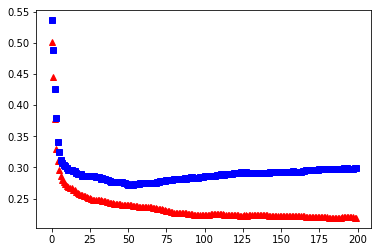

In [37]:
plt.plot(range(0,200), error_rates_train, 'r^', range(0, 200), error_rates_vali, 'bs')
plt.show()

# 梯度检查

In [9]:
np.random.seed(1)
alpha = 1  # learning rate
beta = np.random.randn(X.shape[1]) # 随机初始化参数beta

#dF/dbeta0
prob = np.array(1. / (1 + np.exp(-np.matmul(X, beta)))).ravel()  # 根据当前beta预测离职的概率
prob_y = list(zip(prob, y))
loss = -sum([np.log(p) if y == 1 else np.log(1. - p) for p, y in prob_y]) / len(y) # 计算损失函数的值
deriv = np.zeros(X.shape[1])
for i in range(len(y)):
    deriv += np.asarray(X[i,:]).ravel() * (prob[i] - y[i])
deriv /= len(y)
print('We calculated ' + str(deriv[0]))

delta = 0.0001
beta[0] += delta
prob = np.array(1. / (1 + np.exp(-np.matmul(X, beta)))).ravel()  # 根据当前beta预测离职的概率
prob_y = list(zip(prob, y))
loss2 = -sum([np.log(p) if y == 1 else np.log(1. - p) for p, y in prob_y]) / len(y) # 计算损失函数的值
shouldbe = (loss2 - loss) / delta # (F(b0+delta,b1,...,bn) - F(b0,...bn)) / delta
print('According to definition of gradient, it is ' + str(shouldbe))

We calculated 0.3306924011046167
According to definition of gradient, it is 0.33069903233373665
